In [ ]:
# Mounting to Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Import libraries & resources**

In [ ]:
# import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score

import nltk 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize

In [ ]:
# download the resource
# nltk.download('stopwords')
# nltk.download('punkt')

In [ ]:
# stopwords_english = stopwords.words('english')

In [ ]:
# stopwords_edited = stopwords_english + ['hi', 'hello', 'hey', 'ive', 'just', 'im', 'thanks']

In [ ]:
# stopwords = ['hi', 'hello', 'hey', 'ive', 'just', 'im', 'thanks']

**Load data**

In [ ]:
input_file = '/content/gdrive/My Drive/Monzo/anonymous_labeled_conversations.json'

In [ ]:
data = pd.read_json(input_file, lines=True)

In [ ]:
data.head()

,original_message,tag1,tag2,tag3
0,<p>I was unable to complete an eBay transactio...,APP - Outage,None,None
1,"<p>Hi, I still haven't received my mondo card ...",CARD - Not Arrived,None,None
2,"<p>Hey, I'm liking the new app design but ever...",APP - iOS Bug (known),None,None
3,<p>how come i cannot top up more than £100?</p>,KYC - limit driven,None,None
4,<p>I don't recall this transaction</p>,APP - Unrecognized Transaction,None,None


**Preprocess tags**

In [ ]:
tag_1 = pd.get_dummies(data['tag1'])
tag_2 = pd.get_dummies(data['tag2'])
tag_3 = pd.get_dummies(data['tag3'])

In [ ]:
tags = tag_1.add(tag_2, fill_value=0, axis='columns').clip(upper=1).add(tag_3, fill_value=0, axis='columns').clip(upper=1)

In [ ]:
tags.head()

,3DS,ACCOUNT - Balance Query,ACCOUNT - Change Card Delivery Address,ACCOUNT - Duplicate,ACCOUNT - Limit increase request,ACCOUNT - Unban User,APP - Android Bug (Known),APP - Android Bug (Unknown),APP - Balance Transfer,APP - Bet365,APP - Display error,APP - Logout,APP - Missing Feed Item,APP - Outage,APP - Push Notifications,APP - Receipt Upload,APP - Spending,APP - Tips & Tricks,APP - TouchID,APP - Unrecognized Transaction,APP - iOS Bug (known),ATM - International Issues,ATM - limits,CARD - Damaged,CARD - Duplicate Mailed,CARD - ICVV Failure,CARD - Lost,CARD - Mailing,CARD - Monzo,CARD - Not Arrived,CARD - Replacement,CARD - Royal Mail delays,Careers,DECLINE - Contactless,DECLINE - Merchant Rejected Card,DECLINE - TFL,DECLINE - Timeout,DECLINE - Unknown,DECLINE - not showing in app,DUPLICATE CONVERSATION,...,PAYMENT - Disputed Transaction,PAYMENT - Hanging Auth,PAYMENT - Offline presentment post auth reversal,PAYMENT - Online Issues,PAYMENT - Pay at Pump,PAYMENT - Presentment + Auth,PAYMENT - REFUND,PAYMENT - Transaction Query,PAYMENT - Unexpected Transaction,PIN - sent,PIN - sent via encrypted PDF,PIN - unblock,QUEUE - Bump,TOP UP - 3DS,TOP UP - Bank Transfer (Limits exceeded),TOP UP - Bank Transfer (incorrect reference),TOP UP - Bank blocks Mondo top ups,TOP UP - Bank blocks Monzo top ups,TOP UP - Bank transfer,TOP UP - Bank transfer (international),TOP UP - Bank transfer (no reference),TOP UP - Debit Card,TOP UP - Display error,TOP UP - Limits,TOP UP - Minimum Amount,TOP UP - Misc,TOP UP - Missing load,TOP UP - Missing load (complete),TOP UP - Outage 10/10/16,TOP UP - Refund,TOP UP - unload card,TOP UPS - Misc,TRAVEL - ATM Use,TRAVEL - FX rates,TRAVEL - MTA NYC Decline,TRAVEL - Misc,TRAVEL - Reports,TRAVEL - TfL transaction query,Top Up - Bank Transfer (incorrect reference),Top Up - International Bank Transfer
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# create tag vol table
tags_desc = (data['tag1'].append(data['tag2']).append(data['tag3'])).value_counts().reset_index().rename(columns={'index':'tag', 0:'vol'})

In [ ]:
# extract the top 11 tags
tags_11 = tags[tags_desc['tag'][:11]]

In [ ]:
tags_11.head()

,PIN - sent,CARD - Not Arrived,KYC - limit driven,TOP UP - Bank transfer,PAYMENT - REFUND,APP - iOS Bug (known),APP - Unrecognized Transaction,TRAVEL - TfL transaction query,APP - Outage,TRAVEL - FX rates,DECLINE - Contactless
0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0


In [ ]:
# add the 11 tags to the data
data = pd.concat([data, tags_11], axis=1)

In [ ]:
data.head()

,original_message,tag1,tag2,tag3,PIN - sent,CARD - Not Arrived,KYC - limit driven,TOP UP - Bank transfer,PAYMENT - REFUND,APP - iOS Bug (known),APP - Unrecognized Transaction,TRAVEL - TfL transaction query,APP - Outage,TRAVEL - FX rates,DECLINE - Contactless
0,<p>I was unable to complete an eBay transactio...,APP - Outage,None,None,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0,0.0,0.0
1,"<p>Hi, I still haven't received my mondo card ...",CARD - Not Arrived,None,None,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
2,"<p>Hey, I'm liking the new app design but ever...",APP - iOS Bug (known),None,None,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0,0.0
3,<p>how come i cannot top up more than £100?</p>,KYC - limit driven,None,None,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
4,<p>I don't recall this transaction</p>,APP - Unrecognized Transaction,None,None,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0


In [ ]:
# tags_11_filter = tags_11[tags_11.sum(axis=1) > 0]

In [ ]:
# keep those have 1 in these 11 tags
data = data[tags_11.sum(axis=1) > 0]

In [ ]:
data.shape

(6772, 15)

In [ ]:
# convert 11 tags into one list
data['labels'] = data.loc[:, 'PIN - sent':].values.tolist()

In [ ]:
data.head()

,original_message,tag1,tag2,tag3,PIN - sent,CARD - Not Arrived,KYC - limit driven,TOP UP - Bank transfer,PAYMENT - REFUND,APP - iOS Bug (known),APP - Unrecognized Transaction,TRAVEL - TfL transaction query,APP - Outage,TRAVEL - FX rates,DECLINE - Contactless,labels
0,<p>I was unable to complete an eBay transactio...,APP - Outage,None,None,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
1,"<p>Hi, I still haven't received my mondo card ...",CARD - Not Arrived,None,None,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"<p>Hey, I'm liking the new app design but ever...",APP - iOS Bug (known),None,None,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
3,<p>how come i cannot top up more than £100?</p>,KYC - limit driven,None,None,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,<p>I don't recall this transaction</p>,APP - Unrecognized Transaction,None,None,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."


**Preprocess messages**

In [ ]:
def clean_text(text):
  """Make lower case, remove emoji, remove http tags, remove new line, remove punctuation, remove numbers"""
  
  emoji_pattern = re.compile(
    u"(\ud83d[\ude00-\ude4f])|"  # emoticons
    u"(\ud83c[\udf00-\uffff])|"  # symbols & pictographs (1 of 2)
    u"(\ud83d[\u0000-\uddff])|"  # symbols & pictographs (2 of 2)
    u"(\ud83d[\ude80-\udeff])|"  # transport & map symbols
    u"(\ud83c[\udde0-\uddff])"  # flags (iOS)
    "+", flags=re.UNICODE)

  text = text.lower()
  text = emoji_pattern.sub(r'', text)
  text = re.sub(r'<.*?>', '', text)
  text = re.sub(r'\n', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\w*\d\w*', '', text)

  return text

In [ ]:
# create clean message column
data['text'] = data['original_message'].apply(lambda x: clean_text(x))

In [ ]:
data.head()

,original_message,tag1,tag2,tag3,PIN - sent,CARD - Not Arrived,KYC - limit driven,TOP UP - Bank transfer,PAYMENT - REFUND,APP - iOS Bug (known),APP - Unrecognized Transaction,TRAVEL - TfL transaction query,APP - Outage,TRAVEL - FX rates,DECLINE - Contactless,labels,text
0,<p>I was unable to complete an eBay transactio...,APP - Outage,None,None,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",i was unable to complete an ebay transaction w...
1,"<p>Hi, I still haven't received my mondo card ...",CARD - Not Arrived,None,None,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",hi i still havent received my mondo card and i...
2,"<p>Hey, I'm liking the new app design but ever...",APP - iOS Bug (known),None,None,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",hey im liking the new app design but ever sinc...
3,<p>how come i cannot top up more than £100?</p>,KYC - limit driven,None,None,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",how come i cannot top up more than £
4,<p>I don't recall this transaction</p>,APP - Unrecognized Transaction,None,None,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",i dont recall this transaction


In [ ]:
# data['word_count'] = data['clean_message'].apply(lambda x: len(str(x).split()))

In [ ]:
# def preprocess(text):
#   """Remove stopwords, stemming"""

#   tokenizer = CountVectorizer(stop_words = 'english').build_tokenizer()
#   token = tokenizer(text)

#   # remove_stopwords = [w for w in token if w not in stopwords]

#   # stemmer = PorterStemmer()
#   # stemmed = [stemmer.stem(w) for w in remove_stopwords]

#   combined_text = ' '.join(token)

#   return combined_text

In [ ]:
# data['clean_message'].apply(lambda x: preprocess(x))

0       was unable to complete an ebay transaction wit...
1       hi still havent received my mondo card and it ...
2       hey im liking the new app design but ever sinc...
3                        how come cannot top up more than
4                            dont recall this transaction
                              ...                        
6864     havent use transport for the past couple of days
6865                  hi can have pin reminder sent to me
6866    hey would love to top up on my card is that po...
6867    hi ive completely forgotten my pin could you r...
6868           hey dudes how come keep getting signed out
Name: clean_message, Length: 6869, dtype: object

In [ ]:
# remove messages like below
message_to_remove = ['hey', 'hello', 'hey there', 'hi there', 'hey guys', 'hi', 'hi guys', 'hiya', 'hi monzo', 'good morning', 'hello there', ' ', 'hi all', 'hi team', 'hello hi']

In [ ]:
# data[data['word_count']<=2]['clean_message'].value_counts()

In [ ]:
data_clean = data[~data['text'].isin(message_to_remove)]

In [ ]:
data_clean.head()

,original_message,tag1,tag2,tag3,PIN - sent,CARD - Not Arrived,KYC - limit driven,TOP UP - Bank transfer,PAYMENT - REFUND,APP - iOS Bug (known),APP - Unrecognized Transaction,TRAVEL - TfL transaction query,APP - Outage,TRAVEL - FX rates,DECLINE - Contactless,labels,text
0,<p>I was unable to complete an eBay transactio...,APP - Outage,None,None,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",i was unable to complete an ebay transaction w...
1,"<p>Hi, I still haven't received my mondo card ...",CARD - Not Arrived,None,None,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",hi i still havent received my mondo card and i...
2,"<p>Hey, I'm liking the new app design but ever...",APP - iOS Bug (known),None,None,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",hey im liking the new app design but ever sinc...
3,<p>how come i cannot top up more than £100?</p>,KYC - limit driven,None,None,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",how come i cannot top up more than £
4,<p>I don't recall this transaction</p>,APP - Unrecognized Transaction,None,None,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",i dont recall this transaction


**Model**

Reference: https://towardsdatascience.com/multi-label-classification-using-bert-roberta-xlnet-xlm-and-distilbert-with-simple-transformers-b3e0cda12ce5

https://github.com/ThilinaRajapakse/simpletransformers#a-quick-example

In [ ]:
!pip3 install simpletransformers

In [ ]:
from simpletransformers.classification import MultiLabelClassificationModel

In [ ]:
# create train, eval and test sets
train_df, eval_df = train_test_split(data_clean, test_size=0.3, random_state=99)
eval_df, test_df = train_test_split(eval_df, test_size=0.7, random_state=99)

In [ ]:
print(train_df.shape)
print(eval_df.shape)
print(test_df.shape)

(4669, 17)
(600, 17)
(1401, 17)


In [ ]:
# download and define model
model = MultiLabelClassificationModel('bert'
                                      ,'bert-base-uncased'
                                      ,num_labels=11
                                      # ,use_cuda=False
                                      ,args={'train_batch_size':8
                                             ,'learning_rate': 4e-5
                                             ,'num_train_epochs': 5
                                             ,'max_seq_length':256})

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not 

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
output_dir = '/content/gdrive/My Drive/Monzo/bert_11_labels/'

In [ ]:
# train the model
model.train_model(train_df, output_dir=output_dir)

  0%|          | 0/4669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/584 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/584 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:942: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  model.parameters(), args.max_grad_norm


Running Epoch 2 of 5:   0%|          | 0/584 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/584 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/584 [00:00<?, ?it/s]

(2920, 0.06847335473085715)

In [ ]:
# evaluate model on evaluation set
result, model_outputs, wrong_predictions = model.eval_model(eval_df)

  0%|          | 0/600 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/75 [00:00<?, ?it/s]

In [ ]:
print(result)
print(model_outputs)

{'LRAP': 0.9117865560365561, 'eval_loss': 0.07623266018616656}
[[0.00579834 0.00609589 0.00619125 ... 0.01501465 0.00629044 0.00706482]
 [0.99365234 0.00170708 0.00227928 ... 0.00355148 0.00244331 0.00167465]
 [0.99267578 0.0018034  0.00215721 ... 0.00359344 0.00194931 0.00154305]
 ...
 [0.99316406 0.00171375 0.00227928 ... 0.00345612 0.00226974 0.00156689]
 [0.00328636 0.0026207  0.7734375  ... 0.07385254 0.00186062 0.00220871]
 [0.00656509 0.00471878 0.98583984 ... 0.0050621  0.00349617 0.00374985]]


In [ ]:
eval_output_df = pd.DataFrame(model_outputs, columns=tags_11.columns)

In [ ]:
eval_output_df.head()

,PIN - sent,CARD - Not Arrived,KYC - limit driven,TOP UP - Bank transfer,PAYMENT - REFUND,APP - iOS Bug (known),APP - Unrecognized Transaction,TRAVEL - TfL transaction query,APP - Outage,TRAVEL - FX rates,DECLINE - Contactless
0,0.005798,0.006096,0.006191,0.007347,0.010056,0.015366,0.960449,0.015602,0.015015,0.006290,0.007065
1,0.993652,0.001707,0.002279,0.001949,0.001972,0.002192,0.001831,0.002035,0.003551,0.002443,0.001675
2,0.992676,0.001803,0.002157,0.001897,0.001818,0.001912,0.001694,0.001942,0.003593,0.001949,0.001543
3,0.005981,0.001604,0.366943,0.012009,0.037109,0.005512,0.002663,0.002935,0.507324,0.006363,0.004215
4,0.014732,0.007374,0.008476,0.008156,0.005798,0.013588,0.006798,0.006145,0.005775,0.968750,0.005707


In [ ]:
auc_dict = {}

for col in eval_output_df.columns:
  auc_dict[col] = roc_auc_score(eval_df[col], eval_output_df[col])

In [ ]:
auc_dict

{'APP - Outage': 0.9271071071071071,
 'APP - Unrecognized Transaction': 0.977937940140845,
 'APP - iOS Bug (known)': 0.9763532496722234,
 'CARD - Not Arrived': 0.9627803093896151,
 'DECLINE - Contactless': 0.9424784105320368,
 'KYC - limit driven': 0.9797696061741006,
 'PAYMENT - REFUND': 0.969925499337264,
 'PIN - sent': 0.9921281693763453,
 'TOP UP - Bank transfer': 0.9790496911847277,
 'TRAVEL - FX rates': 0.9921789153900846,
 'TRAVEL - TfL transaction query': 0.9875426047717344}

In [ ]:
pd.DataFrame.from_dict(auc_dict, orient='index').reset_index().rename(columns={'index':'tag', 0:'roc_auc'}).sort_values(by='roc_auc', ascending=False)

,tag,roc_auc
9,TRAVEL - FX rates,0.992179
0,PIN - sent,0.992128
7,TRAVEL - TfL transaction query,0.987543
2,KYC - limit driven,0.979770
3,TOP UP - Bank transfer,0.979050
6,APP - Unrecognized Transaction,0.977938
5,APP - iOS Bug (known),0.976353
4,PAYMENT - REFUND,0.969925
1,CARD - Not Arrived,0.962780
10,DECLINE - Contactless,0.942478


In [ ]:
# evaluate model on test set
result, model_outputs, wrong_predictions = model.eval_model(test_df)

  0%|          | 0/1401 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/176 [00:00<?, ?it/s]

In [ ]:
print(result)

{'LRAP': 0.923681265597754, 'eval_loss': 0.07183188448437829}


In [ ]:
test_output_df = pd.DataFrame(model_outputs, columns=tags_11.columns)

In [ ]:
test_output_df.head()

,PIN - sent,CARD - Not Arrived,KYC - limit driven,TOP UP - Bank transfer,PAYMENT - REFUND,APP - iOS Bug (known),APP - Unrecognized Transaction,TRAVEL - TfL transaction query,APP - Outage,TRAVEL - FX rates,DECLINE - Contactless
0,0.001782,0.003469,0.129150,0.065002,0.677734,0.010902,0.005753,0.001495,0.244385,0.010056,0.007519
1,0.994141,0.001507,0.002279,0.001875,0.001853,0.002003,0.001810,0.001623,0.003651,0.001611,0.001681
2,0.006771,0.014503,0.008781,0.009125,0.005688,0.006218,0.004810,0.006931,0.009338,0.968262,0.007206
3,0.993164,0.001478,0.002100,0.001861,0.001592,0.001965,0.001810,0.001655,0.003780,0.001616,0.001675
4,0.004810,0.003635,0.003824,0.016220,0.971191,0.010651,0.005707,0.005100,0.005981,0.002924,0.003088


In [ ]:
test_output_df.std()

PIN - sent                        0.436630
CARD - Not Arrived                0.314157
KYC - limit driven                0.280773
TOP UP - Bank transfer            0.266487
PAYMENT - REFUND                  0.247067
APP - iOS Bug (known)             0.219608
APP - Unrecognized Transaction    0.206403
TRAVEL - TfL transaction query    0.212996
APP - Outage                      0.185619
TRAVEL - FX rates                 0.214756
DECLINE - Contactless             0.186866
dtype: float64

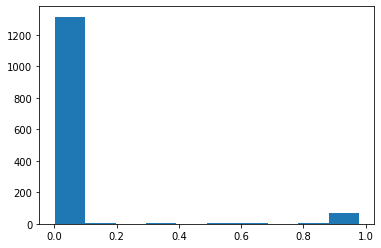

In [ ]:
plt.hist(test_output_df['TRAVEL - FX rates'])
plt.show()

In [ ]:
auc_dict_test = {}
precission_test = {}
recall_test = {}
f1_test = {}
accuracy_test = {}

for col in test_output_df.columns:
  auc_dict_test[col] = roc_auc_score(test_df[col], test_output_df[col])
  precission_test[col] = precision_score(test_df[col], test_output_df[col].apply(lambda x: 1 if x>=0.5 else 0))
  recall_test[col] = recall_score(test_df[col], test_output_df[col].apply(lambda x: 1 if x>=0.5 else 0))
  f1_test[col] = f1_score(test_df[col], test_output_df[col].apply(lambda x: 1 if x>=0.5 else 0))
  accuracy_test[col] = accuracy_score(test_df[col], test_output_df[col].apply(lambda x: 1 if x>=0.5 else 0))

In [ ]:
auc_df = pd.DataFrame.from_dict(auc_dict_test, orient='index').rename(columns={0:'roc_auc'})
precession_df = pd.DataFrame.from_dict(precission_test, orient='index').rename(columns={0:'precision'})
recall_df = pd.DataFrame.from_dict(recall_test, orient='index').rename(columns={0:'recall'})
f1_df = pd.DataFrame.from_dict(f1_test, orient='index').rename(columns={0:'f1'})
accuracy_df = pd.DataFrame.from_dict(accuracy_test, orient='index').rename(columns={0:'accuracy'})

In [ ]:
measure_df = pd.concat([auc_df, accuracy_df, precession_df, recall_df, f1_df], axis=1)

In [ ]:
measure_df.sort_values(by='f1', ascending=False)

,roc_auc,accuracy,precision,recall,f1
PIN - sent,0.992305,0.990721,0.986737,0.978947,0.982827
CARD - Not Arrived,0.993552,0.992148,0.969325,0.963415,0.966361
TRAVEL - FX rates,0.986246,0.989293,0.960526,0.858824,0.906832
KYC - limit driven,0.979140,0.970735,0.886364,0.818182,0.850909
APP - iOS Bug (known),0.981133,0.980728,0.894118,0.808511,0.849162
TRAVEL - TfL transaction query,0.978053,0.982156,0.884615,0.811765,0.846626
PAYMENT - REFUND,0.975968,0.976445,0.796460,0.900000,0.845070
TOP UP - Bank transfer,0.981600,0.970735,0.824427,0.857143,0.840467
DECLINE - Contactless,0.980957,0.982156,0.838710,0.776119,0.806202
APP - Unrecognized Transaction,0.979851,0.975732,0.828947,0.750000,0.787500


In [ ]:
tag_vol = pd.DataFrame(train_df[tags_11.columns].sum()).rename(columns={0:'train_vol'})

In [ ]:
measure_df_2 = pd.concat([measure_df, tag_vol], axis=1)

In [ ]:
measure_df_2.sort_values('f1', ascending=False)

,roc_auc,accuracy,precision,recall,f1,train_vol
PIN - sent,0.990476,0.992862,0.992021,0.981579,0.986772,1295.0
CARD - Not Arrived,0.994634,0.993576,0.964072,0.981707,0.972810,515.0
TRAVEL - FX rates,0.986908,0.989293,0.948718,0.870588,0.907975,245.0
KYC - limit driven,0.989844,0.976445,0.910448,0.853147,0.880866,523.0
PAYMENT - REFUND,0.981111,0.982156,0.864078,0.890000,0.876847,376.0
TOP UP - Bank transfer,0.976001,0.972877,0.843750,0.857143,0.850394,427.0
APP - iOS Bug (known),0.985247,0.980728,0.903614,0.797872,0.847458,333.0
TRAVEL - TfL transaction query,0.981732,0.977873,0.855263,0.764706,0.807453,253.0
DECLINE - Contactless,0.989024,0.980728,0.833333,0.746269,0.787402,211.0
APP - Unrecognized Transaction,0.971730,0.972877,0.794872,0.738095,0.765432,259.0


In [ ]:
np.corrcoef(measure_df_2['f1'], measure_df_2['train_vol'])[0,1]

0.5946788815700824

**Error analysis**

In [ ]:
test_df_ea = test_df[['text', 'APP - Outage']]

In [ ]:
test_df.shape

(1401, 17)

In [ ]:
test_output_df.shape

(1401, 11)

In [ ]:
test_output_df.head()

,PIN - sent,CARD - Not Arrived,KYC - limit driven,TOP UP - Bank transfer,PAYMENT - REFUND,APP - iOS Bug (known),APP - Unrecognized Transaction,TRAVEL - TfL transaction query,APP - Outage,TRAVEL - FX rates,DECLINE - Contactless
0,0.001782,0.003469,0.129150,0.065002,0.677734,0.010902,0.005753,0.001495,0.244385,0.010056,0.007519
1,0.994141,0.001507,0.002279,0.001875,0.001853,0.002003,0.001810,0.001623,0.003651,0.001611,0.001681
2,0.006771,0.014503,0.008781,0.009125,0.005688,0.006218,0.004810,0.006931,0.009338,0.968262,0.007206
3,0.993164,0.001478,0.002100,0.001861,0.001592,0.001965,0.001810,0.001655,0.003780,0.001616,0.001675
4,0.004810,0.003635,0.003824,0.016220,0.971191,0.010651,0.005707,0.005100,0.005981,0.002924,0.003088


In [ ]:
test_output_df = test_output_df.set_index(test_df.index)

In [ ]:
app_pred = pd.DataFrame(test_output_df['APP - Outage'].apply(lambda x: 1 if x>=0.5 else 0)).rename(columns={'APP - Outage':'APP - Outage_pred'}).set_index(test_df.index)

In [ ]:
app_pred.head()

,APP - Outage_pred
3250,0
1431,0
4587,0
4003,0
122,0


In [ ]:
test_df_ea = pd.concat([test_df_ea, app_pred], axis=1)

In [ ]:
test_df_ea.head()

,text,APP - Outage,APP - Outage_pred
3250,hi there i tried to withdraw some money yester...,0.0,0
1431,hi how to find a pin,0.0,0
4587,good afternooni was wondering if you could hel...,0.0,0
4003,hi guysi havent used my monzo card in a couple...,0.0,0
122,hi can someone tell me what has been credited ...,0.0,0


In [ ]:
test_df_ea['error'] = test_df_ea['APP - Outage'] == test_df_ea['APP - Outage_pred']

In [ ]:
pd.options.display.max_colwidth = 200

In [ ]:
print(test_df[['text', 'tag1']][test_df.index==4692])

                                                                                       text               tag1
4692  hi  i am in the us on holiday do i need to let you know so my card doesnt get blocked  TRAVEL - FX rates


In [ ]:
test_output_df[test_df_ea.index==4692]

,PIN - sent,CARD - Not Arrived,KYC - limit driven,TOP UP - Bank transfer,PAYMENT - REFUND,APP - iOS Bug (known),APP - Unrecognized Transaction,TRAVEL - TfL transaction query,APP - Outage,TRAVEL - FX rates,DECLINE - Contactless
4692,0.220337,0.024094,0.01133,0.00433,0.00415,0.027435,0.008095,0.004829,0.721191,0.009636,0.004868


In [ ]:
test_df_ea[(test_df_ea['APP - Outage']==0) & (test_df_ea['APP - Outage_pred']==1)]

,text,APP - Outage,APP - Outage_pred,error
3741,hi i received two transactions of pounds each today that i believe are an error,0.0,1,False
64,my card was just declined for a £ transaction when there is £ balance still on there any idea why,0.0,1,False
2813,hi my balance does not match my transactions,0.0,1,False
6208,hello i had my card rejected today just wondered if you need that info reporting otherwise enjoying my first week with mondo,0.0,1,False
2251,hi i got a payment declined because the withdrawal exceeds the limits however not sure what limits they are referring to i do have enough balance in the card,0.0,1,False
6585,hi guys been having a problem for a few days where my card randomly doesnt work,0.0,1,False
3683,hi there i topped up my card and the ur to use it in a shop and it declined but i have the money in there,0.0,1,False
662,i tried to use my card for the first time and it was declined any idea why,0.0,1,False
3721,hi just chasing my card up,0.0,1,False
6848,hi my monzo account always seems to crash,0.0,1,False
